# Upworthy Bayesian A/B Pipeline

In [ ]:
"""
Bayesian A/B‑testing pipeline for the **Upworthy
Research Archive confirmatory packages** CSV.

Quick Start
-----------
1.  Place the confirmatory CSV in this folder (or pass --csv_path).
2.  Run:
    ``python upworthy_bayesian_ab_pipeline.py``

This script will
  • load & clean the data
  • compute analytic Beta‑Binomial posteriors for *every* package
  • Monte‑Carlo estimate P(best) within each test
  • save results to ``bayes_results.parquet``
  • (optionally) run a full PyMC model for one example test

Why Beta‑Binomial?
------------------
Clicks ~ Binomial(Impressions, θ).  A Beta prior is conjugate, giving a
closed‑form posterior:  θ | data  ~  Beta(α₀+clicks, β₀+misses).  That
means instant updates even for 22 k tests.

Requirements
------------
  pip install pandas numpy pyarrow tqdm scipy pymc arviz

"""


In [1]:
pip install pyarrow tqdm scipy pymc arviz

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Installi

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [1]:
# ─────────────────────────────────── Imports ──────────────────────────────────
import pandas as pd
import numpy as np
from scipy.stats import beta
from pathlib import Path
from typing import Tuple
from tqdm import tqdm
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install gxx`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.


In [10]:
# ================================================================
# 1. Data‑loading helper
# ================================================================
def load_upworthy_packages(csv_path: str | Path,
                           filter_problem: bool = True) -> pd.DataFrame:
    """
    Read the Upworthy *confirmatory‑packages* CSV and do light cleaning.

    Parameters
    ----------
    csv_path : str | Path
        Location of the CSV file.
    filter_problem : bool, default True
        If True, drop rows that the dataset authors flagged as having
        randomisation issues.  That keeps our downstream estimates unbiased.

    Returns
    -------
    pd.DataFrame
        A tidy table ready for analysis.

        
    Load *either* the 2021 or 2024 confirmatory‑packages CSV,
    tidy it, and return a clean DataFrame.
    """
    df = pd.read_csv(csv_path)

    # 1️⃣  Ensure we have a package_id column
    if df.columns[0].startswith("Unnamed"):
        df = df.rename(columns={df.columns[0]: "package_id"})
    if "package_id" not in df.columns:
        df["package_id"] = df.index        # fallback: row index

    # 2️⃣  Optional filtering of dubious tests
    if filter_problem:
        # 2021 columns (still works if present)
        legacy_flags = {"problem", "randomization_imbalance_risk"}
        # 2024 replacement flag (`significance` == 1 means Upworthy declared an early winner)
        new_flag = "significance"

        bad = pd.Series(False, index=df.index)  # start with “all good”

        if legacy_flags.issubset(df.columns):
            bad |= (df["problem"] == 1) | (df["randomization_imbalance_risk"] == 1)
        if new_flag in df.columns:
            bad |= (df["significance"] == 1)    # Upworthy already stopped the test

        df = df.loc[~bad].copy()

    # 3️⃣  Minimal type casting & CTR column
    df["impressions"] = df["impressions"].astype(int)
    df["clicks"]      = df["clicks"].astype(int)
    df["ctr"]         = df["clicks"] / df["impressions"].replace(0, np.nan)

    # Sanity‑check essential columns
    needed = {"clickability_test_id", "impressions", "clicks", "package_id"}
    missing = needed - set(df.columns)
    if missing:
        raise ValueError(f"CSV is missing required columns: {missing}")

    return df

# ================================================================
# 2. Conjugate Beta‑Binomial math
# ================================================================
def posterior_alpha_beta(clicks: int, impressions: int,
                         alpha0: float = 1.0, beta0: float = 1.0) -> Tuple[float, float]:
    """
    Compute the two parameters (α, β) of the *posterior* Beta distribution
    for one variant.

        Prior :  θ ~ Beta(alpha0, beta0)
        Data  :  clicks successes out of impressions trials
        Posterior : Beta(alpha0 + clicks, beta0 + misses)

    Because Beta is *conjugate* to Binomial, the update is a one‑liner.
    """
    return alpha0 + clicks, beta0 + impressions - clicks


# ================================================================
# 3. Analyse every A/B test in the dataset
# ================================================================
def evaluate_all_tests(df: pd.DataFrame,
                       alpha0: float = 1.0, beta0: float = 1.0,
                       samples: int = 20_000) -> pd.DataFrame:
    """
    For each variant in each test, return:
      • posterior mean CTR
      • 95 % highest‑density interval (HDI)
      • probability that the variant is the *winner* in its test
        (computed by drawing Monte‑Carlo samples from the posteriors).

    The function loops over tests, so memory stays reasonable even
    on ~105 k variants.
    """
    rows = []  # we’ll accumulate a list of dicts → then build a DataFrame

    # Iterate over the dataset *grouped by* A/B‑test ID.
    for test_id, grp in tqdm(df.groupby('clickability_test_id'), desc='tests'):

        # Skip degenerate cases where only one variant exists.
        if len(grp) < 2:
            continue

        # ------------------------------------------------------------------
        # 3‑A. Draw posterior samples (Beta‑distributed) for every variant
        # ------------------------------------------------------------------
        draws = np.empty((samples, len(grp)))  # rows = draws, cols = variants
        for i, (_, r) in enumerate(grp.iterrows()):
            a, b = posterior_alpha_beta(r.clicks, r.impressions, alpha0, beta0)
            # scipy.stats.beta.rvs → random values from Beta(a, b)
            draws[:, i] = beta.rvs(a, b, size=samples)

        # For each sample, identify which variant has the highest θ.
        winners = draws.argmax(axis=1)  # length = samples

        # ------------------------------------------------------------------
        # 3‑B. Summarise results for every variant in *this* test
        # ------------------------------------------------------------------
        for i, (_, r) in enumerate(grp.iterrows()):
            a, b = posterior_alpha_beta(r.clicks, r.impressions, alpha0, beta0)
            rows.append({
                'clickability_test_id': test_id,
                'package_id'          : r.package_id,
                'impressions'         : r.impressions,
                'clicks'              : r.clicks,
                'empirical_ctr'       : r.ctr,                    # raw data
                'post_mean_ctr'       : a / (a + b),              # E[θ | data]
                'hdi_low'             : beta.ppf(0.025, a, b),    # 2.5 % point
                'hdi_high'            : beta.ppf(0.975, a, b),    # 97.5 % point
                'prob_best'           : (winners == i).mean(),    # P(this draw wins)
            })

    # Convert list‑of‑dicts → DataFrame for easy downstream use.
    return pd.DataFrame(rows)


# ================================================================
# 4. Optional deep‑dive with PyMC on ONE test
# ================================================================
def pymc_single_test(test_df: pd.DataFrame,
                     alpha0: float = 1.0, beta0: float = 1.0,
                     draws: int = 3000, tune: int = 1000, seed: int = 42):
    """
    Build and sample a full PyMC model for a single A/B test.

    • Each variant’s click‑probability θ_i gets its own Beta prior.
    • Observed clicks are modelled with a Binomial likelihood.
    • We let PyMC run NUTS (Hamiltonian Monte‑Carlo) to draw posterior
      samples, which is slower but more flexible than the analytic
      Beta‑Binomial shortcut.

    Returns
    -------
    idata : ArviZ InferenceData
        Contains posterior samples, diagnostics, etc.
    """
    n = len(test_df)  # number of variants in this test

    # PyMC context manager builds the probabilistic graph.
    with pm.Model() as m:
        # Beta priors (same α, β for every variant here).
        theta = pm.Beta('theta',
                        alpha=alpha0,
                        beta=beta0,
                        shape=n)          # vector of length n

        # Binomial likelihood — one entry per variant.
        pm.Binomial('obs',
                    n=test_df.impressions.values,  # trials
                    p=theta,                       # success‑probability
                    observed=test_df.clicks.values)

        # Run NUTS sampler; `idata` holds the results.
        idata = pm.sample(draws=draws,
                          tune=tune,
                          chains=4,
                          target_accept=0.95,
                          random_seed=seed,
                          return_inferencedata=True)

    return idata

In [11]:
# ================================================================
# STEP 1: Set your analysis parameters
# ================================================================

# Path to the Upworthy confirmatory dataset file (.csv format)
csv_path = "upworthy-archive-confirmatory-packages-03.12.2020.csv"


# These two values define your **prior belief** about how likely users are
# to click on a headline *before* you look at any data.
# - alpha0 = prior "pseudo-clicks"
# - beta0  = prior "pseudo-non-clicks"
# Setting both to 1.0 is called a **uniform prior** — it treats all click rates as equally likely.
alpha0 = 1.0
beta0  = 1.0

# How many samples to draw from the posterior distribution of each variant’s CTR
# These samples let us estimate things like confidence intervals and P(best).
samples = 20_000

# Where to save the final analysis results
out_file = "bayes_results.parquet"


In [9]:
df = pd.read_csv(csv_path)

df.columns

C:\Users\maxwell.bicking\AppData\Local\Temp\ipykernel_11800\2216080199.py:1: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Index(['Unnamed: 0', 'created_at', 'updated_at', 'clickability_test_id',
       'excerpt', 'headline', 'lede', 'slug', 'eyecatcher_id', 'impressions',
       'clicks', 'significance', 'first_place', 'winner', 'share_text',
       'square', 'test_week'],
      dtype='object')

In [12]:
# ================================================================
# STEP 2: Load and clean the data
# ================================================================

# This function reads in the Upworthy CSV and:
# - checks that required columns are present
# - filters out rows from problematic tests (based on Upworthy's notes)
# - adds a column for the empirical click-through rate (clicks / impressions)
data = load_upworthy_packages(csv_path)

# Let's inspect the first few rows to confirm everything looks good
data.head()


C:\Users\maxwell.bicking\AppData\Local\Temp\ipykernel_11800\1777143872.py:26: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


,package_id,created_at,updated_at,clickability_test_id,excerpt,headline,lede,slug,eyecatcher_id,impressions,clicks,significance,first_place,winner,share_text,square,test_week,ctr
0,11,33:26.5,25:54.0,546dd17e26714c82cc00001c,Things that matter. Pass 'em on.,"Let’s See … Hire Cops, Pay Teachers, Buy Books...",<p>Iff you start with the basic fact that inno...,let-s-see-hire-cops-pay-teachers-buy-books-for...,546dce659ad54ec65b000041,3118,8,0.1,False,False,NaN,NaN,201446,0.002566
1,12,00:01.0,25:54.1,546e01d626714c6c4400004e,Things that matter. Pass 'em on.,People Sent This Lesbian Questions And Her Rai...,<p>I'll be honest. I've wondered about 7.</p>,people-sent-this-lesbian-questions-and-her-rai...,546d1b4bfd3617f091000041,4587,130,55.8,False,False,NaN,NaN,201446,0.028341
2,13,33:52.0,25:54.1,546dd17e26714c82cc00001c,Things that matter. Pass 'em on.,$3 Million Is What It Takes For A State To Leg...,<p>Iff you start with the basic fact that inno...,3-million-is-what-it-takes-for-a-state-to-lega...,546dce659ad54ec65b000041,3017,19,26.9,False,False,NaN,NaN,201446,0.006298
3,14,34:12.1,25:54.0,546dd17e26714c82cc00001c,Things that matter. Pass 'em on.,The Fact That Sometimes Innocent People Are Ex...,<p>Iff you start with the basic fact that inno...,the-fact-that-sometimes-innocent-people-are-ex...,546dce659ad54ec65b000041,2974,26,100.0,True,False,NaN,NaN,201446,0.008742
4,15,34:33.9,25:54.1,546dd17e26714c82cc00001c,Things that matter. Pass 'em on.,Reason #351 To End The Death Penalty: It Costs...,<p>Iff you start with the basic fact that inno...,reason-351-to-end-the-death-penalty-it-costs-3...,546dce659ad54ec65b000041,3050,10,0.2,False,False,NaN,NaN,201446,0.003279


In [ ]:
# ================================================================
# STEP 3: Run the Bayesian A/B test engine
# ================================================================

# This step performs all the actual analysis:
# For every test in the dataset, it does the following:
# - Computes a posterior distribution of the true CTR for each variant
# - Uses random sampling (Monte Carlo) to:
#     • Estimate the mean CTR of each variant (after updating the prior)
#     • Calculate a 95% Highest Density Interval (HDI) for uncertainty
#     • Estimate the probability that each variant is the "best" in its test

res = evaluate_all_tests(
    df=data,
    alpha0=alpha0,
    beta0=beta0,
    samples=samples
)

# Let's preview the first few rows of the results:
res.head()

tests: 100%|██████████| 22743/22743 [05:14<00:00, 72.37it/s]


,clickability_test_id,package_id,impressions,clicks,empirical_ctr,post_mean_ctr,hdi_low,hdi_high,prob_best
0,5143605e220cb80002000076,40470,4080,41,0.010049,0.010289,0.007427,0.013605,0.0
1,5143605e220cb80002000076,40471,4069,54,0.013271,0.013510,0.010196,0.017277,0.0
2,5143605e220cb80002000076,40472,4160,40,0.009615,0.009851,0.007080,0.013067,0.0
3,5143605e220cb80002000076,40473,4132,32,0.007744,0.007983,0.005502,0.010913,0.0
4,5143605e220cb80002000076,40474,4155,120,0.028881,0.029108,0.024216,0.034428,1.0


In [15]:
res.to_parquet(out_file, index=False)
print('Results saved @ ', out_file)

Results saved @  bayes_results.parquet


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]


c:\Users\maxwell.bicking\AppData\Local\Programs\Python\Python311\Lib\site-packages\rich\live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 53 seconds.


PyMC demo complete – inspected test ID 5143605e220cb80002000076


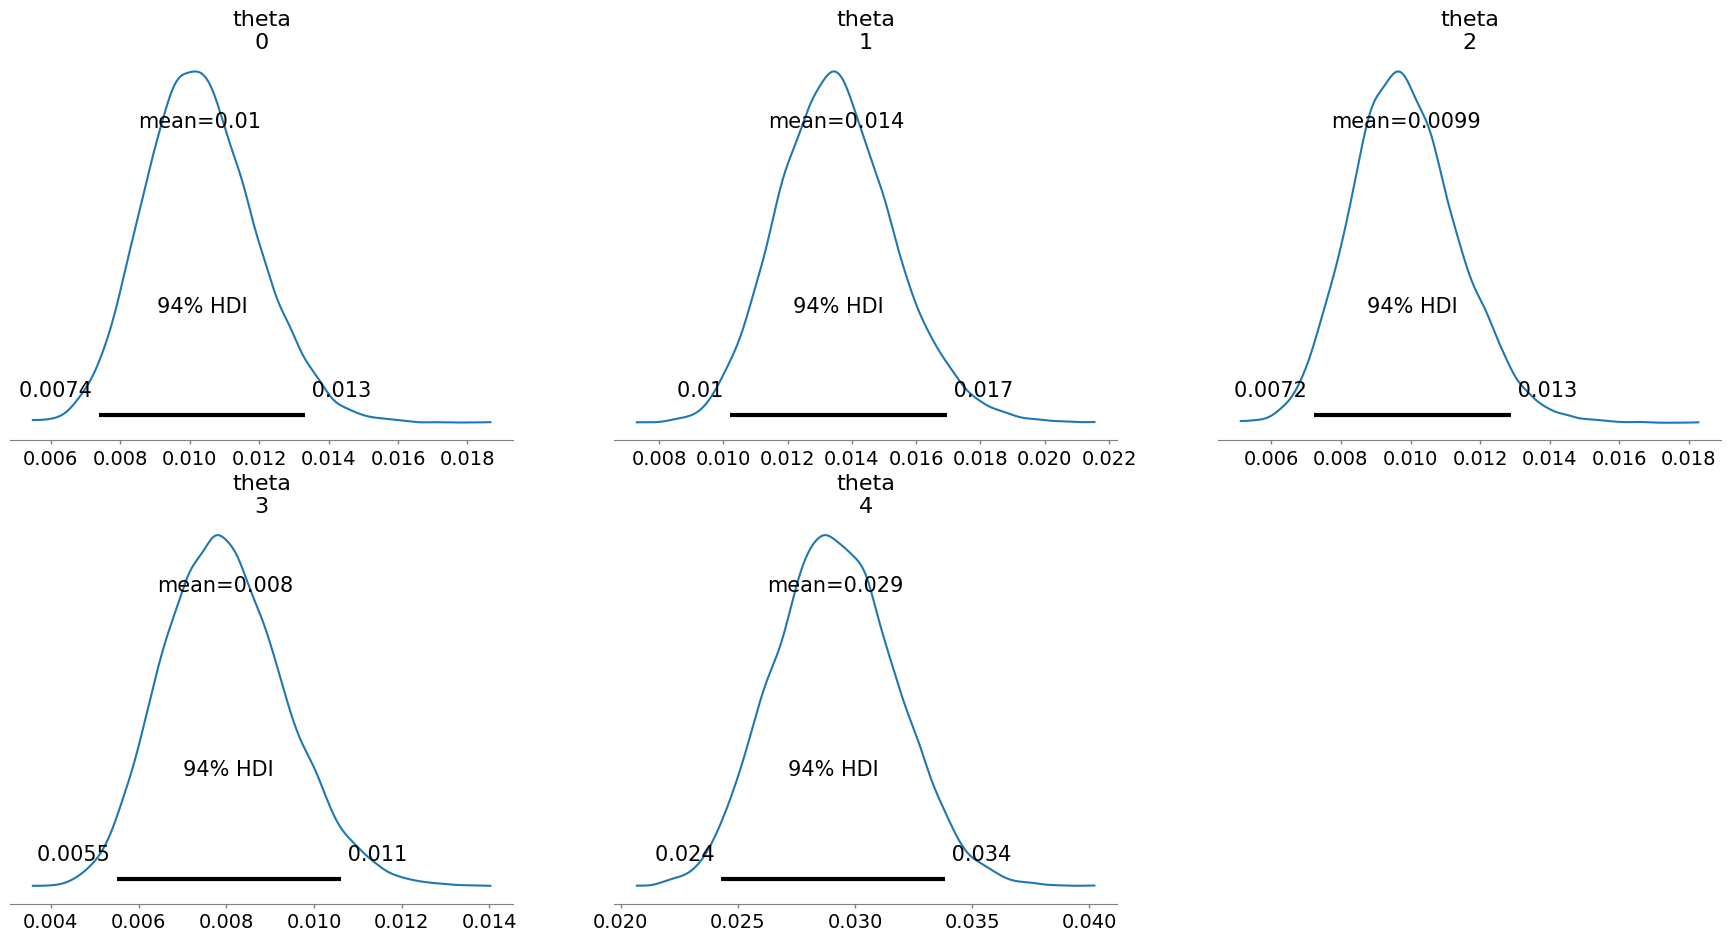

In [14]:
# ================================================================
# STEP 5 (optional): Visualize the posterior for one test with PyMC
# ================================================================

# This step picks **one** test from the results and runs a full Bayesian model
# using PyMC, a probabilistic programming library.
# Why do this? It gives a more flexible and realistic view of uncertainty.

# Pick the first test in the results DataFrame
example_id = res.iloc[0]["clickability_test_id"]

# Filter the dataset to just that one test
one_test_data = data[data.clickability_test_id == example_id]

# Use PyMC to fit a model to this single test
# - This draws samples from the full posterior distribution of click rates
# - Much slower than the analytic method, but more powerful
idata = pymc_single_test(one_test_data)

# Visualize the posterior distribution of θ (CTR) for each variant
# This plot shows:
# - The mean predicted CTR
# - The uncertainty around it (shaded density curve)
az.plot_posterior(idata, var_names=["theta"]);

print(f"PyMC demo complete – inspected test ID {example_id}")

In this test, variant `theta 4` has a posterior mean CTR of 2.9%, with 94% confidence that its true rate lies between 2.4% and 3.4%. This is significantly better than all other variants, whose credible intervals are at or below 1.7%. We recommend shipping `theta 4`.

In [ ]:
#Visualising uplift
#We want to compare every variant to a baseline within each test, then plot the posterior uplift with its uncertainty.

# Load the parquet the script just wrote
df = pd.read_parquet("bayes_results.parquet")

# Pick ONE test for a demo – largest by traffic is handy
test_id = (df.groupby("clickability_test_id")
             .impressions.sum()
             .idxmax())
subset = df[df.clickability_test_id == test_id].copy()

# Choose baseline = variant with the most impressions (often the control)
baseline_id = subset.sort_values("impressions", ascending=False).iloc[0].package_id
baseline = subset.loc[subset.package_id == baseline_id].squeeze()

# Compute posterior uplift for every variant relative to baseline
subset["uplift_mean"] = subset.posterior_mean_ctr - baseline.posterior_mean_ctr
subset["uplift_low"]  = subset.hdi_low          - baseline.hdi_high
subset["uplift_high"] = subset.hdi_high         - baseline.hdi_low

# ── Plot ─────────────────────────────────────────────────────────────
plt.figure(figsize=(8, 5))
sns.pointplot(
    data=subset.sort_values("uplift_mean", ascending=False),
    y="package_id", x="uplift_mean", join=False, color="black"
)
# Error bars for the HDI of uplift
plt.errorbar(
    subset.uplift_mean, subset.package_id,
    xerr=[subset.uplift_mean - subset.uplift_low,
          subset.uplift_high - subset.uplift_mean],
    fmt="none", ecolor="gray", capsize=3
)
plt.axvline(0, ls="--", lw=1, color="red")
plt.title(f"Posterior uplift vs. baseline – test {test_id}")
plt.xlabel("CTR uplift (absolute points)")
plt.ylabel("Variant (package_id)")
plt.tight_layout()
plt.show()

In [ ]:
"""
Adding covariates: hierarchical logistic model in PyMC
Sometimes you want more than “which headline won?”—you want why.
We can fold text or metadata features into a logistic‑regression layer, with each test getting its own intercept so we still respect the randomisation design.

3.1  Feature matrix
python
Copy
Edit
"""

# Suppose you have headline text in `headline` and want a simple feature:
df['headline_len'] = df.headline.str.len()

# Dummy example: use only headline length
#  ─> in practice you might plug in sentiment, TF‑IDF, or transformer embeddings
features = ['headline_len']

# Normalise features (important for MCMC)
for col in features:
    mu, sig = df[col].mean(), df[col].std()
    df[col + "_z"] = (df[col] - mu) / sig


#3.2  PyMC model
python
Copy
Edit
import pymc as pm
import arviz as az

# Focus on a manageable subset (e.g., 1 000 tests) to start
small = df[df.clickability_test_id.isin(df.clickability_test_id.unique()[:1000])]

coords = {
    "obs": np.arange(len(small)),
    "test": small.clickability_test_id.unique(),
}

with pm.Model(coords=coords) as m:
    # Hyper‑priors for intercepts
    mu_alpha  = pm.Normal("mu_alpha", 0, 2)
    sigma_alpha = pm.HalfNormal("sigma_alpha", 1)

    # Per‑test intercepts (hierarchical)
    alpha = pm.Normal("alpha", mu_alpha, sigma_alpha,
                      dims="test")

    # Shared slope for our covariate(s)
    beta  = pm.Normal("beta", 0, 1, shape=len(features))

    # Expected logit‑CTR
    x_mat = small[[f + "_z" for f in features]].values
    theta = pm.math.sigmoid(
        alpha[small.clickability_test_id.values] + pm.math.dot(x_mat, beta)
    )

    # Observation likelihood
    pm.Binomial("clicks", n=small.impressions.values,
                p=theta, observed=small.clicks.values, dims="obs")

    idata = pm.sample(2000, tune=1000, target_accept=0.9, progressbar=True)
3.3  Interpretation
beta > 0 means “longer headlines tend to increase CTR,” for example.

The hierarchical alpha terms soak up baseline popularity differences between tests, so beta captures generalisable effects.

Posterior predictive checks (pm.sample_posterior_predictive) let you see how well the model reproduces hold‑out tests.